ZHONG_YUCHEN_3506497

Double-cliquer ici et remplacer par les noms et prénoms de votre binôme

# 3I026 - Intelligence artificielle & Data science

## TP 2 - k-plus proches voisins (*k-NN*)

Dans ce TP, nous allons principalement mettre en place une "architecture" de code nous permettant petit à petit de tester différents modèles d'apprentissage supervisé et programmer les k-NN. Nous allons nous restreindre au cas binaire où les données sont étiquetées $+1$ ou $-1$.

In [1]:
import numpy as np
import pandas as pd

**Remarque** La concaténation de vecteurs s'obtient à l'aide de la fonction `vstack` de numpy.

### Étape 1: dataset

La première étape consiste à définir une classe permettant de stocker les données d'apprentissage, de validation et de test. Nous considérerons que les données tiennent en mémoire. Nous allons définir une classe permettant de stocker des couples $\{(x_1,y_1),...,(x_n,y_n)\}$. Les $x_i$ et $y_i$ seront des tableaux numpy.

In [2]:
class LabeledSet:  
    
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.nb_examples = 0
    
    def addExample(self,vector,label):
        if (self.nb_examples == 0):
            self.x = np.array([vector])
            self.y = np.array([label])
        else:
            self.x = np.vstack((self.x, vector))
            self.y = np.vstack((self.y, label))
        
        self.nb_examples = self.nb_examples + 1
    
    #Renvoie la dimension de l'espace d'entrée
    def getInputDimension(self):
        return self.input_dimension
    
    #Renvoie le nombre d'exemples dans le set
    def size(self):
        return self.nb_examples
    
    #Renvoie la valeur de x_i
    def getX(self, i):
        return self.x[i]
        
    
    #Renvouie la valeur de y_i
    def getY(self, i):
        return(self.y[i])

#### Génération de données ''Jouet''

Nous allons pour l'instant nous intéresser à des datasets "jouet" générés selon des distributions choisies à la main. Commençons par un dataset en 2 dimensions (entrée) et 1 dimension (sortie): $x_i \in \mathbb{R}^2$, $y_i \in \{-1;+1\}$ tel que les données sont générées selon deux gaussiennes. Pour cela, nous utiliserons la fonction `numpy.random.multivariate_normal` - http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html

- `positive_center` est le centre de la gaussienne des points positifs (vecteur de taille 2)
- `positive_sigma` est la variance de la gaussienne (sous forme de matrice 2*2)
- Idem pour `negative`

Générer une premiere gaussienne associée au label $+1$.

Y ajouter une seconde gaussienne associée au label $-1$.

In [3]:
def generer_exemple(mean=0):
    """Genere un exemple"""
    mean = [mean, mean]
    cov = [[1, 0], [0, 6]]
    return np.random.multivariate_normal(mean, cov)

def generer_exemples(nombre_exemples, mean=0):
    """ Genere une liste de taille 'nombre_exemple' d'exemples """
    exemples = list()
    for _ in range(nombre_exemples):
        exemples.append(generer_exemple(mean))   
    return exemples

def ajouter_exemples_aleatoires(the_set, nombre_exemples, mean, labels):
    """ Ajoute dans 'the_set' un total de 'nombre_exemples' exemples
    associés aleatoirement à un label contenu dans 'labels'. """
    from random import choice
    exemples = generer_exemples(nombre_exemples, mean)
    for exemple in exemples:
        the_set.addExample(exemple, choice(labels))
        
the_set = LabeledSet(2)
ajouter_exemples_aleatoires(the_set, 50, -2, [-1])
ajouter_exemples_aleatoires(the_set, 50, 2, [1])

Le data set peut être affiché en utilisant matplotlib (pour vérifier) et plus précisément la fonction `matplotlib.pyplot.scatter` permettant de dessiner un nuage de points - http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter -

In [4]:
import matplotlib.pyplot as plt
# Permet d'afficher les figures directement dans le notebook:
%matplotlib inline

def plot2DSet(dataset):
    plt.scatter(dataset.x[0:int(dataset.size()/2),0],dataset.x[0:int(dataset.size()/2),1],marker='o')
    plt.scatter(dataset.x[int(dataset.size()/2):dataset.size(),0],dataset.x[int(dataset.size()/2):dataset.size(),1],marker='x')

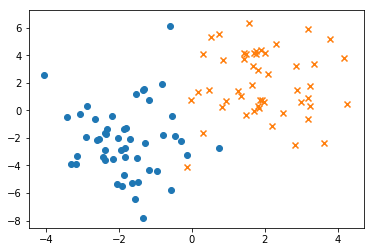

In [5]:
# the_set = # TODO
plot2DSet(the_set)

In [6]:
[generer_exemple() for _ in range(1)]

[array([ 1.79145101, -3.56603922])]

### Étape 2: les classifieurs

Un classifieur (binaire) permet, pour chaque point d'entrée, de calculer un score. Si le score est négatif, la donnée est associée à la classe $-1$, sinon à la classe $+1$. Commençons par définir une classe permettant par la suite de définir plusieurs classifieurs.

Pour l'instant les méthodes `train` et `predict` ne seront pas définies car elles dépendent du modèle.

La fonction `computeAccuracy` renvoie le pourcentage de points bien classés. Elle peut être définie dès maintenant.



In [7]:
class Classifier:
    def __init__(self, input_dimension):
        raise NotImplementedError("Please Implement this method")
    
    
    #Permet de calculer la prediction sur x => renvoie un score
    def predict(self, x):
        raise NotImplementedError("Please Implement this method")

    
    #Permet d'entrainer le modele sur un ensemble de données
    def train(self, labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    #Permet de calculer la qualité du système 
    def accuracy(self, dataset):
        total = dataset.size()
        nb_class = 0.0
        for i in range(total):
            if(self.predict(dataset.getX(i)) == dataset.getY(i)):
                nb_class += 1.0
        return nb_class / total

Nous allons maintenant définir un classifieur linéaire aléatoire :
- la fonction `predict` renvoie la valeur de $\langle x | w\rangle$ où $w$ est un vecteur (de taille `input_dimension`) tiré aléatoirement à la construction du classifieur.


In [8]:
class ClassifierRandom(Classifier):
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.vecteur_w = [generer_exemple() for _ in range(self.input_dimension)]
    
    def predict(self,x):
        res = sum(np.dot(self.vecteur_w,x))
        if res > 0:
            return 1
        else: 
            return -1
    

Nous allons calculer la performance (*accuracy*) du classifieur random sur un ensemble de 100 points

In [9]:
the_set = LabeledSet(2)
#on a un modele et on l'analyse par un autre exemple
ajouter_exemples_aleatoires(the_set, 100, 0, [-1, 1])

c = ClassifierRandom(2)
print(c.accuracy(the_set))

0.52


Voici une fonction qui permet de dessiner la frontière de decision d'un classifieur. La valeur `step` permet de choisir la précision du dessin.

In [10]:
def plot_frontiere(set, classifier, step=20):
    mmax = set.x.max(0)
    mmin = set.x.min(0)
    x1grid, x2grid = np.meshgrid(np.linspace(mmin[0], mmax[0], step), np.linspace(mmin[1], mmax[1], step))
    grid = np.hstack((x1grid.reshape(x1grid.size, 1), x2grid.reshape(x2grid.size, 1)))
    
    # calcul de la prediction pour chaque point de la grille
    res = np.array([classifier.predict(grid[i,:]) for i in range(len(grid)) ])
    res = res.reshape(x1grid.shape)
    # tracé des frontieres
    plt.contourf(x1grid, x2grid, res, colors=["red", "cyan"], levels=[-1000,0,1000], linewidth=2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


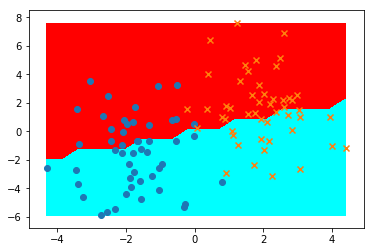

In [11]:
classifieur_random=ClassifierRandom(2)

#on initialise notre dataset et ajoute de nouveaux exemples
the_set = LabeledSet(2)
ajouter_exemples_aleatoires(the_set, 50, -2, [-1])
ajouter_exemples_aleatoires(the_set, 50, 2, [1])

plot_frontiere(the_set,classifieur_random)
plot2DSet(the_set)

### Étape 3 : k-NN

L'objectif est de définir le classifieur k-NN. Pour cela nous allons construire un tableau de distances que nous trierons grâce à la méthode `numpy.argsort`.

In [12]:
#Une fonction calculant la distance entre les deux vecteurs
def dist_vecteur(vect1, vect2):
    return np.sqrt(np.square(vect1[0]-vect2[0])+np.square(vect1[1]-vect2[1]))

class KNN(Classifier):
    def __init__(self, input_dimension, k):
        self.input_dimension = input_dimension
        self.k = k
        
    def predict(self,x):
        res = []
        label = 0
        for val in self.trainning_set.x :
            res.append(dist_vecteur(val,x))
        res = np.array(res)
        res = np.argsort(res) # on trie le tableau de distances de l'ordre croissant et on cherche leur labels correspondantes
        for i in range(self.k):
            indice_label = res[i]
            label += self.trainning_set.getY(indice_label)
        if label > 0 :
            return 1
        else : 
            return -1
    def train(self,dataset):
        self.trainning_set = dataset #on sauvegarde notre "set of examples"
   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.975


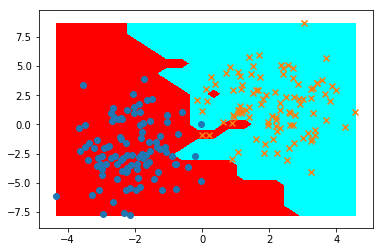

In [13]:
#dataset de l'apprentissage
set_apprentissage = LabeledSet(2)
ajouter_exemples_aleatoires(set_apprentissage, 100, -1, [-1])
ajouter_exemples_aleatoires(set_apprentissage, 100, 1, [1])

#dataset de test
set_test = LabeledSet(2)
ajouter_exemples_aleatoires(set_test, 100, -2, [-1])
ajouter_exemples_aleatoires(set_test, 100, 2, [1])

knn1 = KNN(2,5)
knn1.train(set_apprentissage)
plot_frontiere(set_test,knn1,20)
print(knn1.accuracy(set_test))
plot2DSet(set_test) 


### Étape 4: protocole expérimental

Attention, lorsque vous testez un classifieur, il est nécessaire de considérer à la fois un ensemble d'apprentissage et un ensemble de test. La performance doit être évaluée sur l'ensemble de test (et non pas sur l'ensemble d'apprentissage).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.99


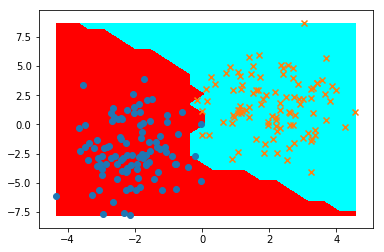

In [14]:
knn2 = KNN(2,20)
knn2.train(set_apprentissage)
plot_frontiere(set_test,knn2,20)
print(knn2.accuracy(set_test))
plot2DSet(set_test) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.99


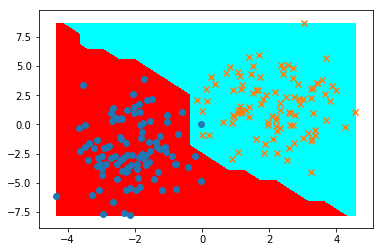

In [15]:
knn3 = KNN(2,50)
knn3.train(set_apprentissage)
plot_frontiere(set_test,knn3,20)
print(knn3.accuracy(set_test))
plot2DSet(set_test) 



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.985


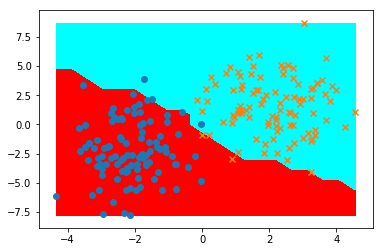

In [18]:
knn4 = KNN(2,100)
knn4.train(set_apprentissage)
plot_frontiere(set_test,knn4,20)
print(knn4.accuracy(set_test))
plot2DSet(set_test) 



#### Travail libre

Comparer la performance (en train et test) de plusieurs classifieurs KNN avec différentes valeurs de k. Que pouvez vous constater ?
Idéalement, vous tracerez la performance (accuracy) en fonction de la valeur de k.
Essayez avec différentes configurations de gaussiennes.

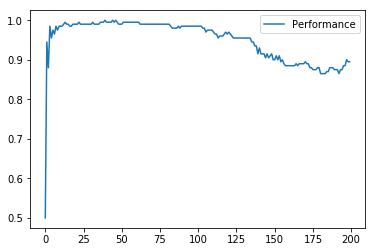

In [17]:
Ks =[]
res = []
for k in range(200):
    knn = KNN(2,k)
    knn.train(set_apprentissage)
    res.append(knn.accuracy(set_test))
dict_res = {
    'Performance' : res
}
df = pd.DataFrame(dict_res)
df.plot(kind='line')
#Conclusion: au fur et mesure de l'augumentation de K, la performance correspondante diminue

### Étape 5 : données réelles UCI

Plusieurs datasets sont téléchargeables depuis: http://mldata.org

Voici la fonction permettant de les charger (en spécifiant leur nom). La fonction se charge de charger les données depuis le web.

In [32]:
from sklearn.datasets import fetch_mldata

def loadFile(name):
    data = fetch_mldata(name, data_home='.')
    print(data.data.shape)
    unique=np.unique(data.target)
    for i in range(len(data.target)):
        if (data.target[i]==unique[0]):
            data.target[i]=1
        else:
            data.target[i]=-1
    return data.data, data.target
datas,targets = loadFile('breast-cancer_scale')
print(datas)
print(targets) #les labels
#Les donnees sont dans data.data et data.target

(683, 10)
[[-0.860107 -0.111111 -1.       ... -0.555556 -1.       -1.      ]
 [-0.859671 -0.111111 -0.333333 ... -0.555556 -0.777778 -1.      ]
 [-0.857807 -0.555556 -1.       ... -0.555556 -1.       -1.      ]
 ...
 [-0.876716 -0.111111  1.       ...  0.555556  1.       -0.777778]
 [-0.875424 -0.333333  0.555556 ...  1.        0.111111 -1.      ]
 [-0.875424 -0.333333  0.555556 ...  1.       -0.333333 -1.      ]]
[ 1  1  1  1  1 -1  1  1  1  1  1  1 -1  1 -1 -1  1  1 -1  1 -1 -1  1  1
 -1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1 -1  1  1 -1  1 -1
 -1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1
 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1  1  1  1 -1  1  1  1  1
 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1  1
  1 -1  1 -1 -1  1  1 -1  1  1 -1 -1  1  1  1  1 -1 -1  1  1  1  1  1 -1
 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1  1  1  1  1  

Écrire la fonction de split permettant de découper les données en un ensemble d'apprentissage et un ensemble de test.

In [39]:
def split(data):
    data_apprentissage = data[:int(len(data)/2)]
    data_test = data[int(len(data)/2):]
    return data_apprentissage, data_test
data_apprentissage, data_test = split(datas)
labels_apprentissage, labels_test = split(targets)
#on verifie si on reussit a separer les datas et les targets 
#print(len(data_apprentissage))
#print(len(data_test))
#print(len(datas))

Tester différents k-NN , pour différents k, et tracer la courbe de performance (accuracy) pour les données d'apprentissage et les données de test.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


0.665


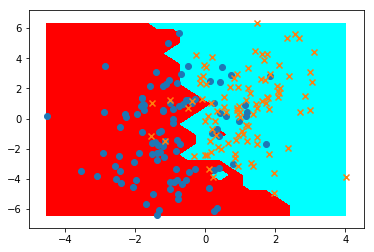

In [42]:
def turn_to_LabeledSet(tab1,tab2):
    set_appretissage = LabeledSet(len(tab1))
    for i in range(len(tab1)):
        set_appretissage.addExample(tab1[i], tab2[i])
    return set_apprentissage
                   
set_apprentissage_real = turn_to_LabeledSet(data_apprentissage,labels_apprentissage)
set_test_real = turn_to_LabeledSet(data_test,labels_test)
                   
knn_real = KNN(set_apprentissage_real.getInputDimension,5)
knn_real.train(set_apprentissage_real)
plot_frontiere(set_test_real,knn_real,20)
print(knn.accuracy(set_test_real))
plot2DSet(set_test_real) 



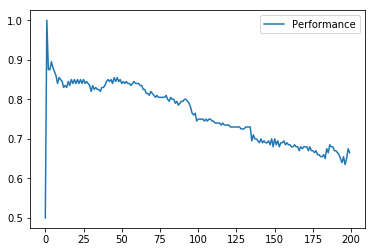

In [43]:
Ks =[]
res = []
for k in range(200):
    knn_real = KNN(set_apprentissage_real.getInputDimension,k)
    knn_real.train(set_apprentissage_real)
    res.append(knn_real.accuracy(set_test_real))
dict_res = {
    'Performance' : res
}
df = pd.DataFrame(dict_res)
df.plot(kind='line')